# 1. Preprocessing and binning

In [2]:
# importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# be careful with that:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# loading data and choosing grid

data_heatmap = pd.read_csv('/Users/xyc/Desktop/ENGI 4800/Criteo/dataset/A_data_heatmap_300x250_3p.csv')
data_metrics = pd.read_csv('/Users/xyc/Desktop/ENGI 4800/Criteo/dataset/A_data_domain_perf_metrics_300x250_3p.csv')

# choose between 333519, 333346

# grid_id = 333346
grid_id = 333519

In [4]:
# uncomment to visualize heatmap data
#data_heatmap

In [5]:
# expand table so that each row corresponds to 1 click:

data_heatmap_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)
data_heatmap_expanded['clicks'] = 1

click_stat = data_heatmap_expanded.groupby(['click_x','click_y'])['clicks'].count().reset_index()

In [6]:
# Binning clicks in nr_of_x_bins, nr_of_y_bins:

NR_OF_X_BINS = 61
NR_OF_Y_BINS = 51

max_width = data_heatmap['display_width'].max()
max_height = data_heatmap['display_height'].max()

width_bins = np.linspace(1, max_width, NR_OF_X_BINS)
height_bins = np.linspace(1, max_height, NR_OF_Y_BINS)

width_bins_max = len(width_bins)-2 # start at 0
height_bins_max = len(height_bins)-2

data_heatmap_expanded['click_x_bin'] = pd.cut(data_heatmap_expanded['click_x'], 
                                      bins = width_bins, 
                                      labels=False, 
                                      include_lowest=True)

data_heatmap_expanded['click_y_bin'] = pd.cut(data_heatmap_expanded['click_y'], 
                                      bins=height_bins, 
                                      labels=False, 
                                      include_lowest=True)


aggregated_clicks = data_heatmap_expanded.groupby(['grid_id',
                                           'domain', 
                                           'click_x_bin', 
                                           'click_y_bin']).size().reset_index(name='clicks_sum')


#aggregated_clicks['clicks_sum'].astype('int64');

In [7]:
# More binning: add empty bins --> easier to generate vectors
# takes a few seconds

from itertools import product

domains_grids = data_heatmap[['domain', 'grid_id']].drop_duplicates()

aux = pd.DataFrame(list(product(range(0,width_bins_max+1), 
                                range(0,height_bins_max+1))), 
                   columns=['click_x_bin', 'click_y_bin'])

domains_grids['key'] = 1
aux['key'] = 1

expanded_set = pd.merge(domains_grids, aux, on='key').drop('key', axis=1)

data_binned = pd.merge(expanded_set, aggregated_clicks, 
                  on = ['domain', 'grid_id', 'click_x_bin', 'click_y_bin'], 
                  how = 'left').fillna(0)
data_binned['clicks_sum'] = data_binned['clicks_sum'].astype('int64')
# data_binned = data_binned[data_binned['grid_id'] == 333519]

In [8]:
# data_binned['grid_id'].unique()

In [9]:
data_binned = data_binned[data_binned['grid_id'] == grid_id]

# 2. PCA code

In [10]:
# create a wide-format DataFrame such that each row corresponds to one heatmap
pivot_df = pd.pivot_table(data_binned, values='clicks_sum', index=['domain', 'grid_id'],
                           columns=['click_x_bin', 'click_y_bin'], aggfunc='sum', fill_value=0)

# Reset index to make 'domain' and 'grid_id' regular columns
pivot_df.reset_index(inplace=True)

# Rename columns to match the desired format
pivot_df.columns = ['domain', 'grid_id'] + [f'clicks_sum_for_{x}_{y}' for x, y in pivot_df.columns[2:]]

# Uncomment to view pivot_df
#print(pivot_df)

In [11]:
input = pivot_df.copy()


In [12]:
# Version 1 of normalizing
# Normalizing such that the total number of clicks in one heatmap sums to one. We do not standardize because standardization assumes the clicks follow a normal distribution, which is not the case
normalized_input = input.copy()

normalized_input.iloc[:,2:] = (input.iloc[:,2:].transpose()/input.iloc[:,2:].sum(axis=1)).transpose()

normalized_input.head()

,domain,grid_id,clicks_sum_for_0_0,clicks_sum_for_0_1,clicks_sum_for_0_2,clicks_sum_for_0_3,clicks_sum_for_0_4,clicks_sum_for_0_5,clicks_sum_for_0_6,clicks_sum_for_0_7,...,clicks_sum_for_59_40,clicks_sum_for_59_41,clicks_sum_for_59_42,clicks_sum_for_59_43,clicks_sum_for_59_44,clicks_sum_for_59_45,clicks_sum_for_59_46,clicks_sum_for_59_47,clicks_sum_for_59_48,clicks_sum_for_59_49
0,ID_1,333519,0.002732,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,ID_10,333519,0.032345,0.013477,0.008086,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,ID_1000,333519,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,ID_1002,333519,0.000000,0.000851,0.000425,0.000425,0.0,0.0,0.000851,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000425,0.0,0.000425,0.0
4,ID_1005,333519,0.000000,0.000581,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000581,0.0,0.000000,0.0,0.000581,0.0


In [13]:
# Version 2 of normalizing, same result as version 1
normalized_input_2 = input.copy()
normalized_input_2.iloc[:,2:] = normalized_input_2.iloc[:,2:].div(normalized_input_2.iloc[:,2:].sum(axis=1), axis=0)
normalized_input_2.head()

,domain,grid_id,clicks_sum_for_0_0,clicks_sum_for_0_1,clicks_sum_for_0_2,clicks_sum_for_0_3,clicks_sum_for_0_4,clicks_sum_for_0_5,clicks_sum_for_0_6,clicks_sum_for_0_7,...,clicks_sum_for_59_40,clicks_sum_for_59_41,clicks_sum_for_59_42,clicks_sum_for_59_43,clicks_sum_for_59_44,clicks_sum_for_59_45,clicks_sum_for_59_46,clicks_sum_for_59_47,clicks_sum_for_59_48,clicks_sum_for_59_49
0,ID_1,333519,0.002732,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,ID_10,333519,0.032345,0.013477,0.008086,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,ID_1000,333519,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,ID_1002,333519,0.000000,0.000851,0.000425,0.000425,0.0,0.0,0.000851,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000425,0.0,0.000425,0.0
4,ID_1005,333519,0.000000,0.000581,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000581,0.0,0.000000,0.0,0.000581,0.0


In [14]:
input['nb_clicks'] = input.iloc[:,  2:].sum(axis=1)
input.head()

,domain,grid_id,clicks_sum_for_0_0,clicks_sum_for_0_1,clicks_sum_for_0_2,clicks_sum_for_0_3,clicks_sum_for_0_4,clicks_sum_for_0_5,clicks_sum_for_0_6,clicks_sum_for_0_7,...,clicks_sum_for_59_41,clicks_sum_for_59_42,clicks_sum_for_59_43,clicks_sum_for_59_44,clicks_sum_for_59_45,clicks_sum_for_59_46,clicks_sum_for_59_47,clicks_sum_for_59_48,clicks_sum_for_59_49,nb_clicks
0,ID_1,333519,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,366
1,ID_10,333519,12,5,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,371
2,ID_1000,333519,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,378
3,ID_1002,333519,0,2,1,1,0,0,2,0,...,0,0,0,0,0,1,0,1,0,2351
4,ID_1005,333519,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1720


In [15]:
# # Test code
# data = np.ones((5,  5))
# df = pd.DataFrame(data)
# df_nb = df.copy()
# df_nb['nb_clicks'] = df_nb.iloc[:,  2:].sum(axis=1)
# df_nb

In [16]:
# # Version 2 of normalizing
# df_2 = df.copy()
# df_2.iloc[:,2:] = df_2.iloc[:,2:].div(df_2.iloc[:,2:].sum(axis=1), axis=0)

# df_2.head()

In [17]:
# # Test code
# df_1 = df.copy()
# df_1.iloc[:,2:] = (df_1.iloc[:,2:].transpose()/df_1.iloc[:,2:].sum(axis=1)).transpose()
# df_1

In [18]:
# Plot explained variance ratio

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

features = normalized_input.columns[2:] #input.columns[1:]  # Exclude the first column, which is the index

# Select the number of components (in this case, reduce to 2 dimensions)
n_components = 200

# Instantiate the PCA model
# pca = PCA(n_components=n_components)

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])

# Fit and transform the data
pca_result = pipeline.fit_transform(normalized_input[features])

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])

# Concatenate the first column (index) from pca_input to pca_df
pca_df['domain'] = normalized_input['domain']

# Display the resulting DataFrame
#print(pca_df)

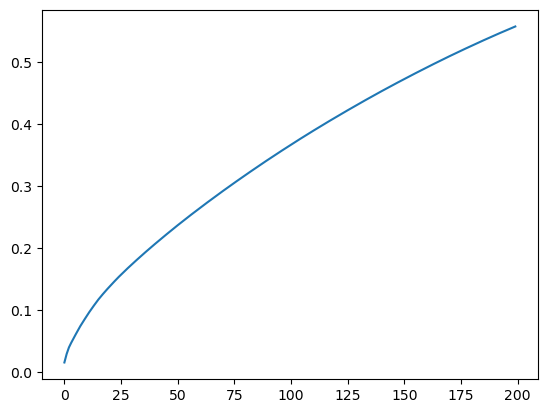

In [19]:
# Plot the cumulative explained variance ratio by the first k eigenvectors
pca_object = pipeline.named_steps['pca']
pca_exp_var = pca_object.explained_variance_ratio_
plt.plot(np.cumsum(pca_exp_var))

# print(sum(pca_exp_var[:2]))

In [20]:
# PCA to n = 2

features = normalized_input.columns[2:] #input.columns[1:]  # Exclude the first column, which is the index

# Select the number of components (in this case, reduce to 2 dimensions)
n_components = 2

# Instantiate the PCA model
# pca = PCA(n_components=n_components)

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])

# Fit and transform the data
pca_result = pipeline.fit_transform(normalized_input[features])

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])

# Concatenate the first column (index) from pca_input to pca_df
pca_df['domain'] = normalized_input['domain']

In [21]:
cb_333519 = ['ID_1184', 'ID_1281', 'ID_1305', 'ID_1353', 'ID_1448', 'ID_1522',
       'ID_1544', 'ID_162', 'ID_1682', 'ID_1690', 'ID_1824', 'ID_1888',
       'ID_1929', 'ID_2076', 'ID_2097', 'ID_2226', 'ID_2249', 'ID_2268',
       'ID_2331', 'ID_2339', 'ID_2386', 'ID_2396', 'ID_2438', 'ID_258',
       'ID_2609', 'ID_2680', 'ID_2863', 'ID_2883', 'ID_2908', 'ID_3061',
       'ID_3243', 'ID_3250', 'ID_3314', 'ID_3382', 'ID_3397', 'ID_3402',
       'ID_3420', 'ID_3459', 'ID_3470', 'ID_3540', 'ID_398', 'ID_409',
       'ID_484', 'ID_489', 'ID_526', 'ID_549', 'ID_580', 'ID_665',
       'ID_810', 'ID_84', 'ID_857', 'ID_86', 'ID_905', 'ID_927', 'ID_934',
       'ID_962', 'ID_986']

In [22]:
cb_333346 = ['ID_1247', 'ID_162', 'ID_2534', 'ID_2742', 'ID_526', 'ID_2201',
       'ID_1165', 'ID_743', 'ID_199', 'ID_2145', 'ID_2569', 'ID_643',
       'ID_1305', 'ID_3180', 'ID_3158', 'ID_136', 'ID_293', 'ID_1753',
       'ID_1849', 'ID_2226', 'ID_1462', 'ID_626', 'ID_2863', 'ID_3243',
       'ID_3250', 'ID_1708', 'ID_1238', 'ID_580', 'ID_84', 'ID_2568',
       'ID_2340', 'ID_1803', 'ID_3470', 'ID_139', 'ID_2619', 'ID_2908',
       'ID_1281', 'ID_3308', 'ID_2883', 'ID_1320', 'ID_1333', 'ID_1062',
       'ID_149', 'ID_260', 'ID_599', 'ID_1513', 'ID_3402', 'ID_1888',
       'ID_2972', 'ID_398', 'ID_2339', 'ID_1030', 'ID_3382', 'ID_2076',
       'ID_1646', 'ID_1077', 'ID_10', 'ID_1153', 'ID_1533', 'ID_2609',
       'ID_1214', 'ID_810', 'ID_2097', 'ID_2386', 'ID_1585', 'ID_549',
       'ID_3420', 'ID_3397', 'ID_2006', 'ID_561', 'ID_1542', 'ID_1570',
       'ID_1819', 'ID_1413', 'ID_1240', 'ID_793', 'ID_831', 'ID_3188',
       'ID_1437', 'ID_556', 'ID_1134', 'ID_314', 'ID_2836', 'ID_1483',
       'ID_2676', 'ID_665', 'ID_15', 'ID_2755', 'ID_2194', 'ID_1682',
       'ID_2775', 'ID_1923', 'ID_1846', 'ID_1262', 'ID_3314', 'ID_1448',
       'ID_1770', 'ID_2626', 'ID_3296', 'ID_489', 'ID_1963', 'ID_1268',
       'ID_1568', 'ID_1094', 'ID_2267', 'ID_409', 'ID_1650', 'ID_1522',
       'ID_927', 'ID_2302', 'ID_1929', 'ID_1435', 'ID_1353']

In [23]:
# Labelling points with ground truth

if grid_id == 333346:
    cb = cb_333346
elif grid_id == 333519:
    cb = cb_333519
pca_df['label'] = 0

pca_df.loc[pca_df.domain.isin(cb),'label'] = 1
pca_df['label'].sum()

57

In [24]:
print(grid_id)

333519


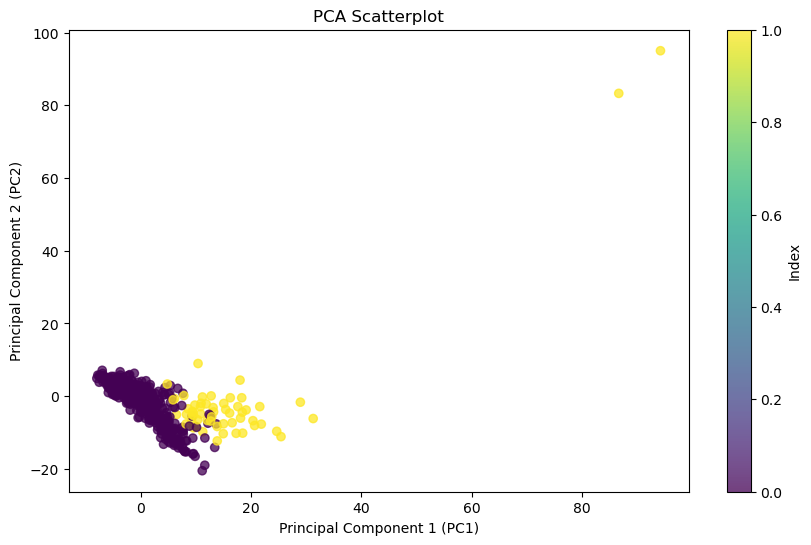

In [25]:
# Plotting pca_df with ground truth labels
pca_df1 = pca_df
plt.figure(figsize=(10, 6))
plt.scatter(pca_df1['PC1'], pca_df1['PC2'], c=pca_df1['label'], cmap='viridis', alpha=0.75)
plt.title('PCA Scatterplot')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')

plt.show()

# plt.savefig(f'PCA_gridid_{grid_id}.jpg')

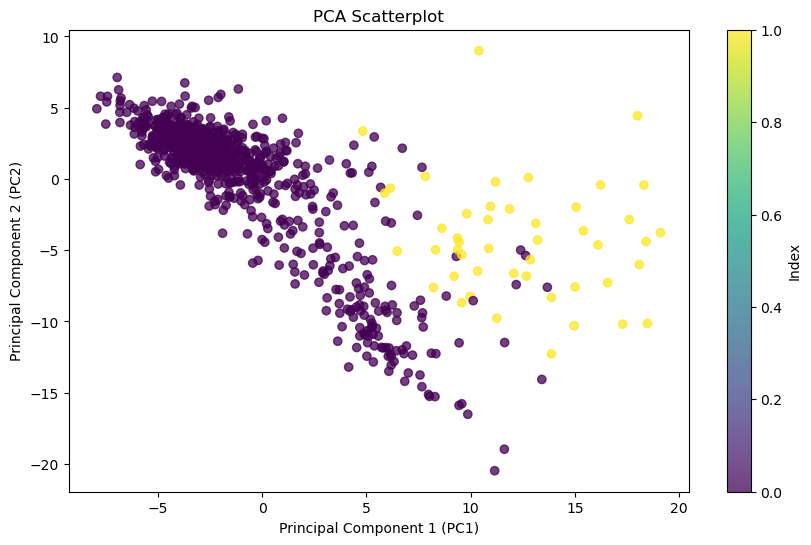

In [26]:
# Zoomed plot of pca_df with ground truth labels

pca_df1 = pca_df[pca_df.PC1<20]
plt.figure(figsize=(10, 6))
plt.scatter(pca_df1['PC1'], pca_df1['PC2'], c=pca_df1['label'], cmap='viridis', alpha=0.75)
plt.title('PCA Scatterplot')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')

# plt.show()

plt.savefig(f'PCA_gridid_{grid_id}.jpg')

# 3. Train-test split on 333519

In [27]:
print(grid_id)

333519


In [28]:
normalized_input['label'] = 0
normalized_input.loc[normalized_input.domain.isin(cb),'label'] = 1
normalized_input.head(10)

,domain,grid_id,clicks_sum_for_0_0,clicks_sum_for_0_1,clicks_sum_for_0_2,clicks_sum_for_0_3,clicks_sum_for_0_4,clicks_sum_for_0_5,clicks_sum_for_0_6,clicks_sum_for_0_7,...,clicks_sum_for_59_41,clicks_sum_for_59_42,clicks_sum_for_59_43,clicks_sum_for_59_44,clicks_sum_for_59_45,clicks_sum_for_59_46,clicks_sum_for_59_47,clicks_sum_for_59_48,clicks_sum_for_59_49,label
0,ID_1,333519,0.002732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0
1,ID_10,333519,0.032345,0.013477,0.008086,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0
2,ID_1000,333519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0
3,ID_1002,333519,0.000000,0.000851,0.000425,0.000425,0.000000,0.000000,0.000851,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000425,0.0,0.000425,0.000000,0
4,ID_1005,333519,0.000000,0.000581,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000581,0.000000,0.000000,0.0,0.000581,0.000000,0
5,ID_1010,333519,0.000000,0.000000,0.003861,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0
6,ID_1021,333519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0
7,ID_1024,333519,0.000000,0.000000,0.000000,0.000000,0.000000,0.002320,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.002320,0
8,ID_1037,333519,0.000351,0.000176,0.000176,0.000351,0.000176,0.000351,0.000351,0.0,...,0.000176,0.0,0.000351,0.000351,0.000351,0.000176,0.0,0.000176,0.000176,0
9,ID_1040,333519,0.000000,0.000000,0.004405,0.000000,0.004405,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0


In [29]:
from sklearn.model_selection import train_test_split

X = normalized_input.iloc[:,2:-1]
y = normalized_input.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
print(y_train)

544    0
398    0
764    0
312    0
326    0
      ..
106    0
270    0
860    0
435    0
102    0
Name: label, Length: 697, dtype: int64


In [31]:
index = 0

while y_train.iloc[index] == 0:
    index += 1
    # y_train.iloc[index]

print(index)

12


In [32]:
n_components = 2

# Instantiate the PCA model
pca_train = PCA(n_components=n_components)

# Fit and transform the data
train_result = pca_train.fit_transform(X_train)

# Create a DataFrame with the PCA results
train_result_df = pd.DataFrame(data=train_result, columns=[f'PC{i+1}' for i in range(n_components)])

train_result_df.set_index(X_train.index)

# train_result_df['label'] = y_train
train_result_df = train_result_df.assign(label=y_train.values)


In [33]:
train_result_df

,PC1,PC2,label
0,-0.002092,-0.000885,0
1,-0.004508,-0.002241,0
2,-0.006359,-0.003359,0
3,-0.004026,-0.001931,0
4,-0.002733,-0.001253,0
...,...,...,...
692,-0.003565,-0.001881,0
693,0.003560,0.001316,0
694,-0.004324,-0.001842,0
695,-0.003768,-0.001436,0


# K-NN

In [34]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = 5
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Fit the model on the training data
knn.fit(train_result_df[['PC1', 'PC2']], train_result_df['label'])

# Make predictions on the test data
test_result = pca_train.transform(X_test)
test_result_df = pd.DataFrame(data=test_result, columns=['PC1', 'PC2'])
test_result_df.set_index(X_test.index)
test_result_df = test_result_df.assign(label=y_test.values)

# Predict labels for the test data
predicted_labels = knn.predict(test_result_df[['PC1', 'PC2']])

# Evaluate the model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate accuracy
accuracy = accuracy_score(test_result_df['label'], predicted_labels)

# Print the accuracy
print(f'Accuracy: {accuracy:.4f}')

# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(test_result_df['label'], predicted_labels))

# Print the classification report
print('Classification Report:')
print(classification_report(test_result_df['label'], predicted_labels))


Accuracy: 0.9714
Confusion Matrix:
[[157   2]
 [  3  13]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       159
           1       0.87      0.81      0.84        16

    accuracy                           0.97       175
   macro avg       0.92      0.90      0.91       175
weighted avg       0.97      0.97      0.97       175



KNN model performed quite well based on the accuracy and other metrics from the classification report. 

The model correctly predicted the label for approximately 97.14% of the test set.

The confusion matrix shows a low number of false positives and false negatives, meaning that the model did not often mistake one class for the other.
TP: 157
FN: 2
FP: 3
TN: 13

In the classification report, the precision for class 0 is very high at 0.98, meaning that when the model predicts class 0, it is correct 98% of the time. Recall for class 0 is also high, at 0.99, indicating that the model successfully captures 99% of actual class 0 instances.


In [48]:
# Result for the whole dataset (train+test)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np

# Applying PCA to the entire dataset (train + test)
all_data_pca = pca_train.transform(normalized_input.iloc[:, 2:-1])

# Creating a DataFrame for the PCA-transformed data
all_data_pca_df = pd.DataFrame(data=all_data_pca, columns=['PC1', 'PC2'])

# Adding the labels back to the DataFrame
all_data_pca_df['label'] = y.values

# Training the KNN model on the entire dataset
knn_full = KNeighborsClassifier(n_neighbors=5)
knn_full.fit(all_data_pca_df[['PC1', 'PC2']], all_data_pca_df['label'])

# Making predictions on the entire dataset
all_data_predicted_labels = knn_full.predict(all_data_pca_df[['PC1', 'PC2']])

# Calculating the accuracy on the entire dataset
all_data_accuracy = accuracy_score(all_data_pca_df['label'], all_data_predicted_labels)

# Generating the confusion matrix and classification report for the entire dataset
all_data_conf_matrix = confusion_matrix(all_data_pca_df['label'], all_data_predicted_labels)
all_data_class_report = classification_report(all_data_pca_df['label'], all_data_predicted_labels)

# Print the accuracy
print(f'Accuracy: {all_data_accuracy:.4f}')

# Print the confusion matrix
print('Confusion Matrix:')
print(all_data_conf_matrix)

# Print the classification report
print('Classification Report:')
print(all_data_class_report)


Accuracy: 0.9862
Confusion Matrix:
[[810   5]
 [  7  50]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       815
           1       0.91      0.88      0.89        57

    accuracy                           0.99       872
   macro avg       0.95      0.94      0.94       872
weighted avg       0.99      0.99      0.99       872



# CV - does not work

In [90]:
# CV to find best n-components and best k-neighbors
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Create a pipeline that standardizes the data, applies PCA, and then applies KNN
pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

# Define the grid of parameters to search over
param_grid = {
    'pca__n_components': [2, 3, 5, 10, 15, 20, 50, 100], 
    'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 20] 
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# X and y are your features and target variable
# Use the non-normalized features here since the pipeline will normalize them
X = input.iloc[:,2:-1] 
y = input.iloc[:,-1] 

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated score: ", grid_search.best_score_)

best_pipeline = grid_search.best_estimator_


Best parameters found:  {'knn__n_neighbors': 3, 'pca__n_components': 2}
Best cross-validated score:  0.014916256157635468


In [67]:
# Another method for CV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

# Set up the ranges for the parameters you want to search
n_components_options = [2, 3, 5, 10, 15, 20, 50, 100]
n_neighbors_options = [1, 3, 5, 7, 9, 11, 13, 15, 20]

# To keep track of the best score and corresponding parameters
best_score = 0
best_params = {'pca__n_components': None, 'knn__n_neighbors': None}

# Loop over all combinations of parameters
for n_components in n_components_options:
    for n_neighbors in n_neighbors_options:
        
        # Set up the pipeline
        pipeline = Pipeline([
            ('scaling', StandardScaler()),
            ('pca', PCA(n_components=n_components)),
            ('knn', KNeighborsClassifier(n_neighbors=n_neighbors))
        ])
        
        # Perform cross-validation
        scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
        
        # Compute the mean score
        mean_score = np.mean(scores)
        
        # If the score from this parameter combination is the best so far, save the score and parameters
        if mean_score > best_score:
            best_score = mean_score
            best_params['pca__n_components'] = n_components
            best_params['knn__n_neighbors'] = n_neighbors

# Print out the best score and the corresponding parameters
print(f"Best score: {best_score}")
print(f"Best parameters: {best_params}")


Best score: 0.014916256157635468
Best parameters: {'pca__n_components': 2, 'knn__n_neighbors': 3}


The score seems not correct, the dataset is unbalanced.